# **Diplomado de Machine Learning con Python**
## Tarea 06 – Sesión 09 (PCA FULL)

## **Aplicación de Análisis de Componentes Principales (PCA)**

📊 En esta tarea se aborda la aplicación del Análisis de Componentes Principales (PCA) como parte del preprocesamiento en flujos de machine learning y como técnica de reducción de dimensionalidad en un conjunto de datos multivariado.

PCA permite transformar un conjunto de variables posiblemente correlacionadas en un nuevo espacio de componentes ortogonales, preservando la mayor cantidad posible de varianza original. El objetivo es transformar las variables numéricas en un espacio de menor dimensión que conserve la mayor parte de la varianza explicada, facilitando tanto la visualización como el modelado posterior.

El proceso se dividirá en dos etapas principales:

1. Preprocesamiento del conjunto original.

2. Aplicación del flujo a datos nuevos no vistos.

Para esta tarea se utilizará el **Palmer Penguins Dataset** y se realizará la etapa 1 de este proceso. 


## Importación de librerías y lectura de archivo csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# --- Cargar CSV (ajusta la ruta si hace falta) ---
df = pd.read_csv("palmer_penguins_pca.csv")

df.head()

,id,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Revisión inicial de los datos

In [2]:
# Resumen de los datos

d_type = df.dtypes # Tipo de dato
n_non_null = df.count() # Numero de valores no nulos
n_unique = df.nunique() # Numero de valores unicos
n_null = df.isnull().sum() # Numero de valors nulos
ratio_null = df.isnull().sum()/df.shape[0] # Porcentaje de valores nulos

pd.DataFrame(
    {"d_type": d_type,
     "n_non_null": n_non_null,
     "n_unique": n_unique,
     "n_null": n_null,
     "ratio_null": ratio_null}
)

,d_type,n_non_null,n_unique,n_null,ratio_null
id,int64,334,334,0,0.000000
species,object,334,3,0,0.000000
island,object,334,3,0,0.000000
bill_length_mm,float64,332,161,2,0.005988
bill_depth_mm,float64,332,79,2,0.005988
flipper_length_mm,float64,332,55,2,0.005988
body_mass_g,float64,332,93,2,0.005988
sex,object,323,2,11,0.032934
year,int64,334,3,0,0.000000


## Separación de datos de entrenamiento y prueba (X_train, X_test, y_train, y_test)

In [3]:
# Separar variables predictoras (X) y variable objetivo (y)
y = df['species']
X = df.drop(columns=['species'])

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,                # Matriz de variables predictoras
    y,                # Vector de variable objetivo
    test_size=0.20,   # Proporción del conjunto de prueba (20%)
    random_state=0,   # Semilla para reproducibilidad
    shuffle=True,     # Mezcla los datos aleatoriamente antes de dividirlos
    stratify=y        # Asegura que la distribución de clases se mantenga en ambos conjuntos
)

# Revisar tamaños
print("Shapes -> X_train:", X_train.shape, " | X_test:", X_test.shape)

Shapes -> X_train: (267, 8)  | X_test: (67, 8)


## Separación de variables numéricas y categóricas

In [4]:
cols_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cols_cat = ["island", "sex"]

X_train_num = X_train[cols_num]
X_train_cat = X_train[cols_cat]
X_test_num = X_test[cols_num]
X_test_cat = X_test[cols_cat]

In [5]:
X_train_num.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
266,45.2,14.8,212.0,5200.0
162,49.3,15.7,217.0,5850.0
326,45.6,19.4,194.0,3525.0
241,46.9,14.6,222.0,4875.0
85,38.9,18.8,190.0,3600.0


## Preprocesamiento de variables categoricas

In [6]:
# --- Codificado CATEGORICAS
# Columnas
cols_onehot  = ['island', 'sex']  # NOMINALES → One-Hot Encoding
cols_ordinal = []  # ORDINALES → Ordinal Encoding

# Categorías ordenadas para las ordinales (mismo orden que en cols_ordinal)
categorias_ordinales = [] # lista de listas

# --- Pipelines CATEGÓRICOS
pipe_cat_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

'''pipe_cat_ord = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OrdinalEncoder(categories=categorias_ordinales,
                               handle_unknown="use_encoded_value", unknown_value=-1))
])'''


# --- Construcción de ColumnTransformer ---
preprocessor_cat = ColumnTransformer(
    transformers=[
        ("cat_ohe",      pipe_cat_ohe,  cols_onehot),
        #("cat_ord",      pipe_cat_ord,  cols_ordinal),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---------- Ajuste y transformación
preprocessor_cat.fit(X_train_cat)

X_train_cat_proc = preprocessor_cat.transform(X_train_cat)
X_test_cat_proc = preprocessor_cat.transform(X_test_cat)

# -----------------------------------------
# Renombrar One-Hot a formato col___categoria
# -----------------------------------------
onehot = preprocessor_cat.named_transformers_.get("onehot")

rename_map = {}
if onehot is not None and len(cols_onehot) > 0:
    for col, cats in zip(cols_onehot, onehot.categories_):
        for cat in cats:
            old = f"{col}_{cat}"      # nombre que entrega sklearn con verbose_feature_names_out=False
            new = f"{col}___{cat}"    # triple guion bajo deseado
            rename_map[old] = new

# Obtener nombres del ColumnTransformer y aplicar renombres solo a OHE
cols_out_cat = preprocessor_cat.get_feature_names_out()
cols_out_cat = [rename_map.get(c, c) for c in cols_out_cat]

# Reconstruir DataFrames con índices originales
df_train_cat_encode = pd.DataFrame(X_train_cat_proc, columns=cols_out_cat, index=X_train_cat.index)
df_test_cat_encode  = pd.DataFrame(X_test_cat_proc,  columns=cols_out_cat, index=X_test_cat.index)


In [7]:
df_test_cat_encode.head()

,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
271,0.0,1.0,0.0,1.0,0.0
36,0.0,1.0,0.0,0.0,1.0
324,0.0,1.0,0.0,0.0,1.0
168,1.0,0.0,0.0,1.0,0.0
49,1.0,0.0,0.0,1.0,0.0


## Preprocesamiento de variables numéricas

### Creación de funciones para análisis de outliers y rangos acotados



In [8]:
# ============================================================
# Creación de funciones auxiliares para diagnostico de columnas
# ============================================================

# 1) Detecta numéricas
print("Columnas numéricas:", cols_num)

# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup

def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None

Columnas numéricas: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


### Visualización exploratoria de las columnas numéricas


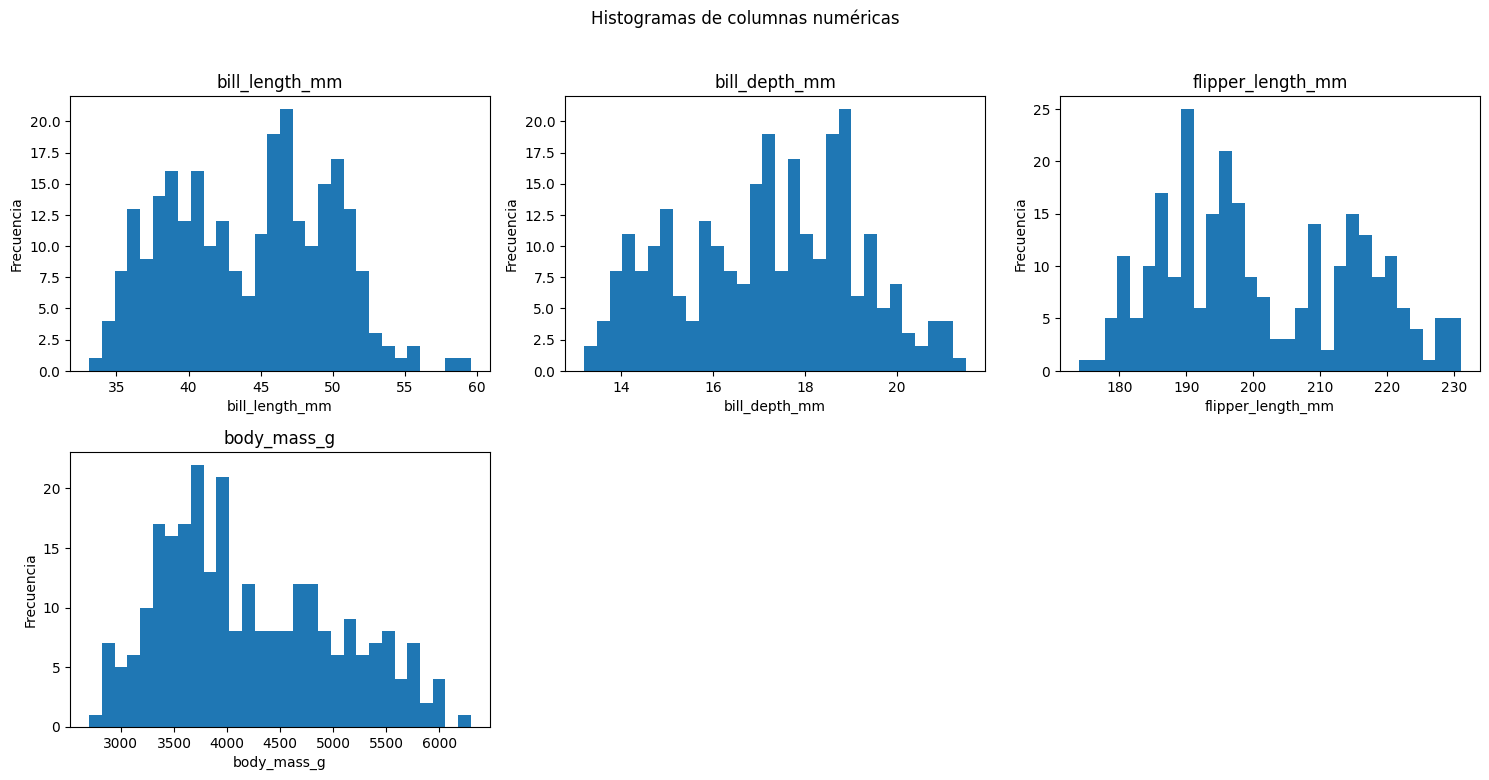

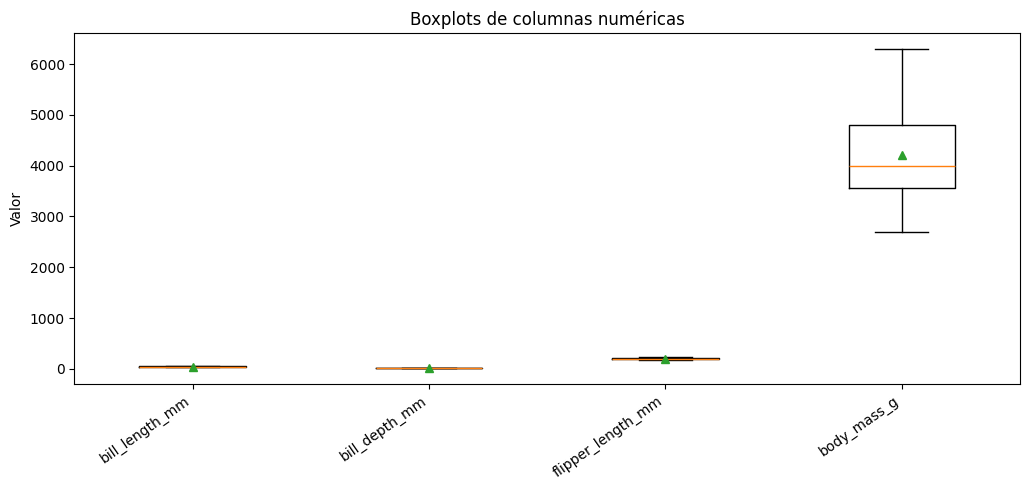

In [9]:
# =======================================
# Generación de gráficos para diagnóstico
# =======================================

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.show()
    #plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.show()
        #plt.close(fig2)

### Diagnóstico automatizado de columnas númericas


In [10]:
# ================================
# Diagnóstico numérico + heurística
# ================================

diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)

    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")

print(diag_df) # Imprime el DataFrame con estadísticas y recomendaciones por variable
print("\n", diag_df[['columna', 'recom_imputer', 'recom_scaler']]) # Imprime solo las recomendaciones por variable

# =====================================================================
# Agrupacíón automática de las columnas según el tratamiento recomendado
# =====================================================================

# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)


=== Diagnóstico numérico (heurística) ===

             columna  missing_%   skew  kurtosis  outliers_n  outliers_%  \
0     bill_length_mm       0.75  0.060    -0.887           0         0.0   
1      bill_depth_mm       0.75 -0.098    -0.871           0         0.0   
2  flipper_length_mm       0.75  0.300    -1.036           0         0.0   
3        body_mass_g       0.75  0.453    -0.770           0         0.0   

       q1      q3     IQR  lim_inf  lim_sup  bounded recom_imputer  \
0    39.5    48.5     9.0     26.0     62.0  [0,100]          mean   
1    15.7    18.7     3.0     11.2     23.2  [0,100]          mean   
2   190.0   214.0    24.0    154.0    250.0     None          mean   
3  3550.0  4800.0  1250.0   1675.0   6675.0     None          mean   

     recom_scaler  
0  StandardScaler  
1  StandardScaler  
2  StandardScaler  
3  StandardScaler  

              columna recom_imputer    recom_scaler
0     bill_length_mm          mean  StandardScaler
1      bill_depth_mm

### Listas de columnas numéricas agrupadas por tipo de tratamiento


In [11]:
# --- Listas de columnas ---
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

#########################################################
#########################################################

#num_med_rob_cols = []   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
#num_mean_min_cols  = []    # media + MinMax
num_mean_std_cols  = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']    # media + Estandar

#########################################################
#########################################################

#passthrough_cols = []                      # pasar sin procesar
#drop_cols        = []                         # eliminar

#########################################################
#########################################################


### Definición de los pipelines numéricos de preprocesamiento


In [12]:
# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])'''

'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''

'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''


'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

'''pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])'''

pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])

### Construcción del ColumnTransformer para preprocesamiento


In [13]:
# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        #("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        #("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        ("num_mean_std",  pipe_mean_std,  num_mean_std_cols),

        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",                        # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)

# Visualizar preprocessor
preprocessor_num


ColumnTransformer(transformers=[('num_mean_std',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['bill_length_mm', 'bill_depth_mm',
                                  'flipper_length_mm', 'body_mass_g'])],
                  verbose_feature_names_out=False)

## Aplicación de Componentes Principales (PCA) sobre las variables numéricas

### Estimación de componentes principales

In [14]:
# ==========================================
# ANÁLISIS GRÁFICO DE PCA (antes de calcular T)
# ==========================================

from sklearn.decomposition import PCA

# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),               # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),   # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])

# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num_mean_std',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g'])],
                                   verbose_feature_names_out=False)),
                ('std_for_pca', StandardScaler()),
                ('pca', PCA(random_state=0, svd_solver='full'))])

#### Análisis del espectro de varianza explicada

In [15]:
# Espectro

# Extrae la varianza explicada
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
# Calcula la varianza acumulada
cum  = np.cumsum(expl)
ks   = np.arange(1, len(expl)+1)

# Sugiere valores óptimos de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)

# Detecta el “codo” del espectro - “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1

# Imprimir resultados
print("Varianza explicada (primeros 10):", np.round(expl[:10], 6))
print("Acumulada (primeros 10):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")

Varianza explicada (primeros 10): [0.684648 0.194398 0.092299 0.028655]
Acumulada (primeros 10):          [0.684648 0.879046 0.971345 1.      ]
Sugerencias -> k@90%=3, k@95%=3, k(elbow)=3


#### Generación de gráficos - Scree Plot y Varianza **Acumulada**

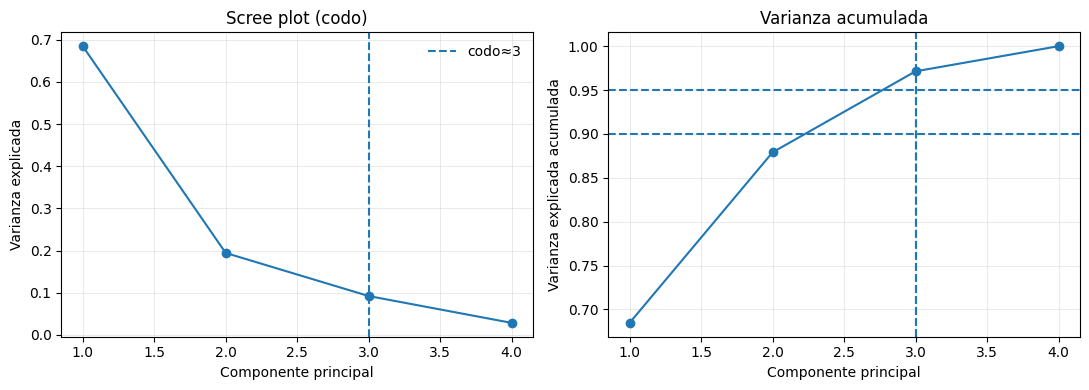

In [16]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)

# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--"); axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--"); axs[1].axvline(k95, linestyle="--")

plt.tight_layout(); plt.show()

### Aplicación de PCA con reducción dimensional utilizando el número óptimo de componentes `k`

In [17]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)

###############################################
###############################################
k = k_elbow
###############################################
###############################################

pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),             # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
###############################################
###############################################
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),
###############################################
###############################################
])

# --- FIT en train ---
pca_pipe.fit(X_train_num)

# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num)
T_test  = pca_pipe.transform(X_test_num)

# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num.index)

# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))

# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)

print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head())

Varianza explicada: [0.684648 0.194398 0.092299]
Acumulada: [0.684648 0.879046 0.971345]
Shapes -> T_train: (267, 3) | T_test: (67, 3)


,PC1,PC2,PC3
266,1.705613,-0.770829,-0.263173
162,2.508129,0.110800,-0.541235
326,-1.083891,1.006624,0.293017
241,2.081650,-0.681690,0.053286
85,-1.634249,0.020510,-0.348854


### Visualización en 2D de los datos transformados por PCA

In [18]:
# Solo si k >= 2
import plotly.express as px

df_plot2 = T_train_df.iloc[:, :2].copy()
df_plot2["objetivo"] = y_train.loc[T_train_df.index].astype(str)
fig2 = px.scatter(df_plot2, x="PC1", y="PC2", color="objetivo",
                  opacity=0.85, title="PC1 vs PC2 por ‘objetivo’ (train)", height=550)
fig2.update_traces(marker=dict(size=6))
fig2.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig2.show()

### Visualización en 3D de los datos transformados por PCA

In [19]:
#### Solo si k>=3
df_plot = T_train_df.iloc[:, :3].copy()          # PC1, PC2, PC3
# Alinea objetivo con los índices de T_train_df
df_plot["objetivo"] = y_train.loc[T_train_df.index].astype(str)

fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="objetivo",
    opacity=0.85,
    title="PC1–PC2–PC3 por ‘objetivo’ (train)",
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()

## Construcción final del conjunto de datos preprocesado

Aquí se combinan los componentes principales obtenidos por PCA (variables numéricas reducidas) con las variables categóricas codificadas.

In [20]:
# === Concatenar PCs (numéricas) con categóricas codificadas ===
# Asegura alineación por índice
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode  = df_test_cat_encode.reindex(T_test_df.index)

T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final  = pd.concat([T_test_df,  df_test_cat_encode], axis=1)

# Añadir columna objetivo (alineada por índice)
T_train_final_out = T_train_final.copy()
T_test_final_out  = T_test_final.copy()

T_train_final_out["objetivo"] = y_train.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"]  = y_test.loc[T_test_final.index].astype(str)


print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)

T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)
# X_train_final.head()


T_train_final: (267, 8)
T_test_final : (67, 8)


In [21]:
T_train_final_out

,PC1,PC2,PC3,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male,objetivo
266,1.705613,-0.770829,-0.263173,1.0,0.0,0.0,1.0,0.0,Gentoo
162,2.508129,0.110800,-0.541235,1.0,0.0,0.0,0.0,1.0,Gentoo
326,-1.083891,1.006624,0.293017,0.0,1.0,0.0,1.0,0.0,Chinstrap
241,2.081650,-0.681690,0.053286,1.0,0.0,0.0,1.0,0.0,Gentoo
85,-1.634249,0.020510,-0.348854,0.0,1.0,0.0,1.0,0.0,Adelie
...,...,...,...,...,...,...,...,...,...
264,1.829562,-0.824617,0.242280,1.0,0.0,0.0,1.0,0.0,Gentoo
319,-0.633085,0.161107,0.731049,0.0,1.0,0.0,1.0,0.0,Chinstrap
11,-1.803291,-0.268681,0.600851,0.0,0.0,1.0,1.0,0.0,Adelie
130,-1.695664,-0.577787,0.001007,0.0,1.0,0.0,1.0,0.0,Adelie


## Guardado de artefactos clave para reproducibilidad

In [22]:
# === Guardar artefactos ===
import joblib
import json

# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")   # (preprocessor_num + StdScaler + PCA)

# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,            # columnas numéricas originales
    "cols_cat": cols_cat,            # columnas categóricas originales
    "pc_cols": list(T_train_df.columns),            # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)


## Compresión y empaquetado de artefactos clave

In [23]:
import os, zipfile, glob

# Carpeta destino en tu PC
dst_dir = r"mi_pca"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "pca_artifacts_bundle.zip")

# Archivos que quieres incluir (ajusta si te falta alguno)
candidates = [
    "T_test_PCA.csv",
    "T_test_final.csv",
    "T_test_final_objetivo.csv",
    "T_train_PCA.csv",
    "T_train_final.csv",
    "T_train_final_objetivo.csv",
    "boxplots_numericas.png",
    "histogramas_numericas.png",
    "palmer_penguins_pca.csv",
    "pca_metadata.json",
    "pca_pipe_num.joblib",
    "preprocessor_cat.joblib",
]

present = [f for f in candidates if os.path.exists(f)]
# Si quieres incluir una carpeta (p. ej., 'sample_data'), descomenta:
# for root, _, files in os.walk("sample_data"):
#     for f in files:
#         present.append(os.path.join(root, f))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in present:
        zf.write(f, arcname=os.path.basename(f))  # guarda sin subcarpetas

print("ZIP creado en:", zip_path)
print("Incluidos:", present)


ZIP creado en: mi_pca/pca_artifacts_bundle.zip
Incluidos: ['T_test_PCA.csv', 'T_test_final.csv', 'T_test_final_objetivo.csv', 'T_train_PCA.csv', 'T_train_final.csv', 'T_train_final_objetivo.csv', 'boxplots_numericas.png', 'histogramas_numericas.png', 'palmer_penguins_pca.csv', 'pca_metadata.json', 'pca_pipe_num.joblib', 'preprocessor_cat.joblib']
